<a href="https://colab.research.google.com/github/hollyemblem/raschka-llm-from-scratch/blob/main/chapter4_implementing_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coding LLM Architecture

A high-level view of the architecture required for predicting one word (token) at a time.

Text -> Tokenized text -> Embeddings -> One or more Transformer blocks w/ multi-headed attention -> Output layers

### Parameter Size and Changes

In the previous chapter notebooks, we had small embedding dimensions so we could manually calculate the components of things like attention mechanisms. Now, we're scaling up to the small GPT model of 124 million parameters like [the GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (note, they originally state 117 million, but this was corrected).

#### What are parameters?
Parameters are trainable weights that are adjusted and optimised during training to minimise the loss function.

#### How do we calculate the number of parameters?

Imagine we have a neural network with a 2048 x 2048 trainable weight matrix. Every value in this matrix is a parameter, so we have 2048 x 2048 = 4,194,304 parameters.

## GPT Config


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [3]:
### Implementing a placeholder GPT class

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        '''the embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID.'''

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(               #1 Transformer block placeholder
            *[DummyTransformerBlock(cfg)               #1 Transformer block placeholder
              for _ in range(cfg["n_layers"])]         #1 Transformer block placeholder
        )                                              #1 Transformer block placeholder
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])     #2 Layer norm placeholder
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False #take an input of 768 and output 50257
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        print("Hidden representation shape:", x.shape)  # ← THIS IS 768
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):    #3 placeholder class
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):     #4 placeholder forward pass
        '''
        forward method describes the data flow through the model: it computes token and positional embeddings for the input indices,
        applies dropout, processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.
        '''
        return x

class DummyLayerNorm(nn.Module):           #5
    def __init__(self, normalized_shape, eps=1e-5):    #6 placeholder layernorm
        super().__init__()

    def forward(self, x):
        return x

### Tokenising Text

In [4]:
!pip install tiktoken

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
##Initialise dummy GPT model and feed it tokenized batch
'''The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector
This represents one score per vocabulary token
'''

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


Hidden representation shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [7]:
batch.shape

torch.Size([2, 4])

In [8]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [9]:
##Tokeniser creates a batch of 2 with 4 tokens in
##This is then passed to embedding layers as part of GPTModel
# Each text sample consists of 4 tokens; each token is a 50257 dimensional vector matching tiktoken's bpe config
'''
token ids
   ↓
embedding lookup
   ↓
(batch, seq, 768)   ← internal representation
   ↓
linear projection
   ↓
(batch, seq, 50257) ← logits
'''

'\ntoken ids\n   ↓\nembedding lookup\n   ↓\n(batch, seq, 768)   ← internal representation\n   ↓\nlinear projection\n   ↓\n(batch, seq, 50257) ← logits\n'

In [10]:
'''This is the embedding matrix. A row per token and a column per dimension'''
print(model.tok_emb.weight.shape)

torch.Size([50257, 768])


### Thinking about the shape of the inputs and outputs

One of the slightly confusing elements of the book is how this is stated:

> The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer’s vocabulary.

> The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. When we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.

It can be a bit difficult to follow this, we know that we go from a 768 dimension embedding with a vocab size of 50,257, but it's not really clear what's happening to then get to the logit out.

From working through the logic, we use a linear layer to go from a 768-dim embedding to 50,257 dimension of token scores.

When we train the model, we'll use the 768 dimension semantic space, but we'll then 'predict' by looking at the token scores across a 50,257 dimension.

A good tip to remember that for this GPT-2 example, the weight matrix (embeddings) are:



```
print(model.tok_emb.weight.shape)
```
which is 50,257 rows (one row per possible token) and 768 columns (one column per embedding dimension)

Adapting from Chapter 3:

> "In other words, the embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID."

The embedding dimension "represents the embedding size, transforming each token into a 768-dimensional vector"

Therefore, we create a 50,257 x 768 matrix. This then goes through a linear layer to output 'logits'. In the batch example, this has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.




## Normalizing activations with layer normalization

Challenge associated with training deep neural networks are:

- Exploding gradients: Large error gradients accumulate
- Vanishing gradients: Weights become extremely small during backpropagation

We use layer normalisation to improve stability and efficiency of model during training.

Adjust the activations of the NN to have a mean of 0 and variance of 1 (apply unit variance).



In [11]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)     #1
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) ##Adding a linear layer plus a nonlinear activation function, ReLU (short for rectified linear unit)
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [12]:
##Examine the mean and variance
mean = out.mean(dim=-1, keepdim=True) ##-1 = apply to the columns. 0 would apply across the rows
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [13]:
##Normalising

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
### Encapsulating changes in class

In [15]:
class LayerNorm(nn.Module):
    '''
    This specific implementation of layer normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim).
    The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization.

    Model can adjust scale and shift during training to improve performance - allows for learning appropriate scaling and shift for the task.
    '''

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) #trainable parameter
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #trainable parameter

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) ##Setting to true uses Besset's correction to adjust for bias and is n-1 in denominator, not n.
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [16]:
##Trying layer norm
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 Implementing a feed forward network with GELU activations

In [17]:
##Implementing the GPT approximation of GELU activation

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        '''
        The GELU activation function can be implemented in several ways;
        the exact version is defined as GELU(x) = x⋅𝛷(x), where 𝛷(x) is the cumulative distribution function of the standard Gaussian distribution.
        In practice, however, it’s common to implement a computationally cheaper approximation
        '''
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

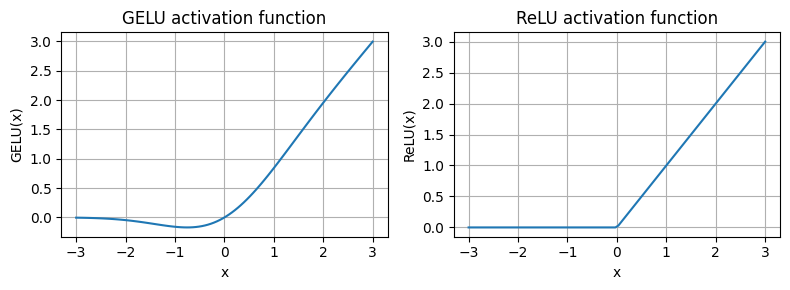

In [18]:
##Plotting RELU and GELU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)     #1
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Why use GELU?

- Smoothness leads to better optimisation during training. RELU's sharp corner at 0 can make optimisation harder.
- GELU allows small non-zero output for negative values. This means neurons that receive negative input can still contribute to the learning process.

In [19]:
### Adding GeLU to a small feedforward class we'll be using later in TFs.
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)          #1
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


While input and output dimensions are the same, we expand the embedding dimension into a higher dimensional space with the following:



```
 nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"])
```

This allows for greater exploration of a richer representation space. Then we move back down to our original dimensions:



```
nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
```

Shrinking back down to normal also allows us too stack multiple layers, rather than adjusting dimensions between them.


## Adding Short-cut Connections

Skip/residual/short-cut connections were originally used typically in CV to mitigate challenges associated with vanishing gradients.



#### What are short-cut connections?

- They create an alternative path for the gradient to flow through the NN by skipping one or more layers.

- Achieved by adding the output of one layer to the output of a later layer.


In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([       #1 5 linear layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)         #2 get output from current layer
            if self.use_shortcut and x.shape == layer_output.shape:    # if use short cute is true, then add the shortcut connection
                x = x + layer_output
            else:
                x = layer_output
        return x

In [22]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)                            #1
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [23]:
##Compute the gradients
def print_gradients(model, x):
    output = model(x)             #1
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)    #2

    loss.backward()          #3

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [24]:
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

In [25]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [26]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846952389925718
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


>"The last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress toward the first layer (layers.0) and doesn’t shrink to a vanishingly small value."

## 4.5 Connecting attention and linear layers in a transformer block

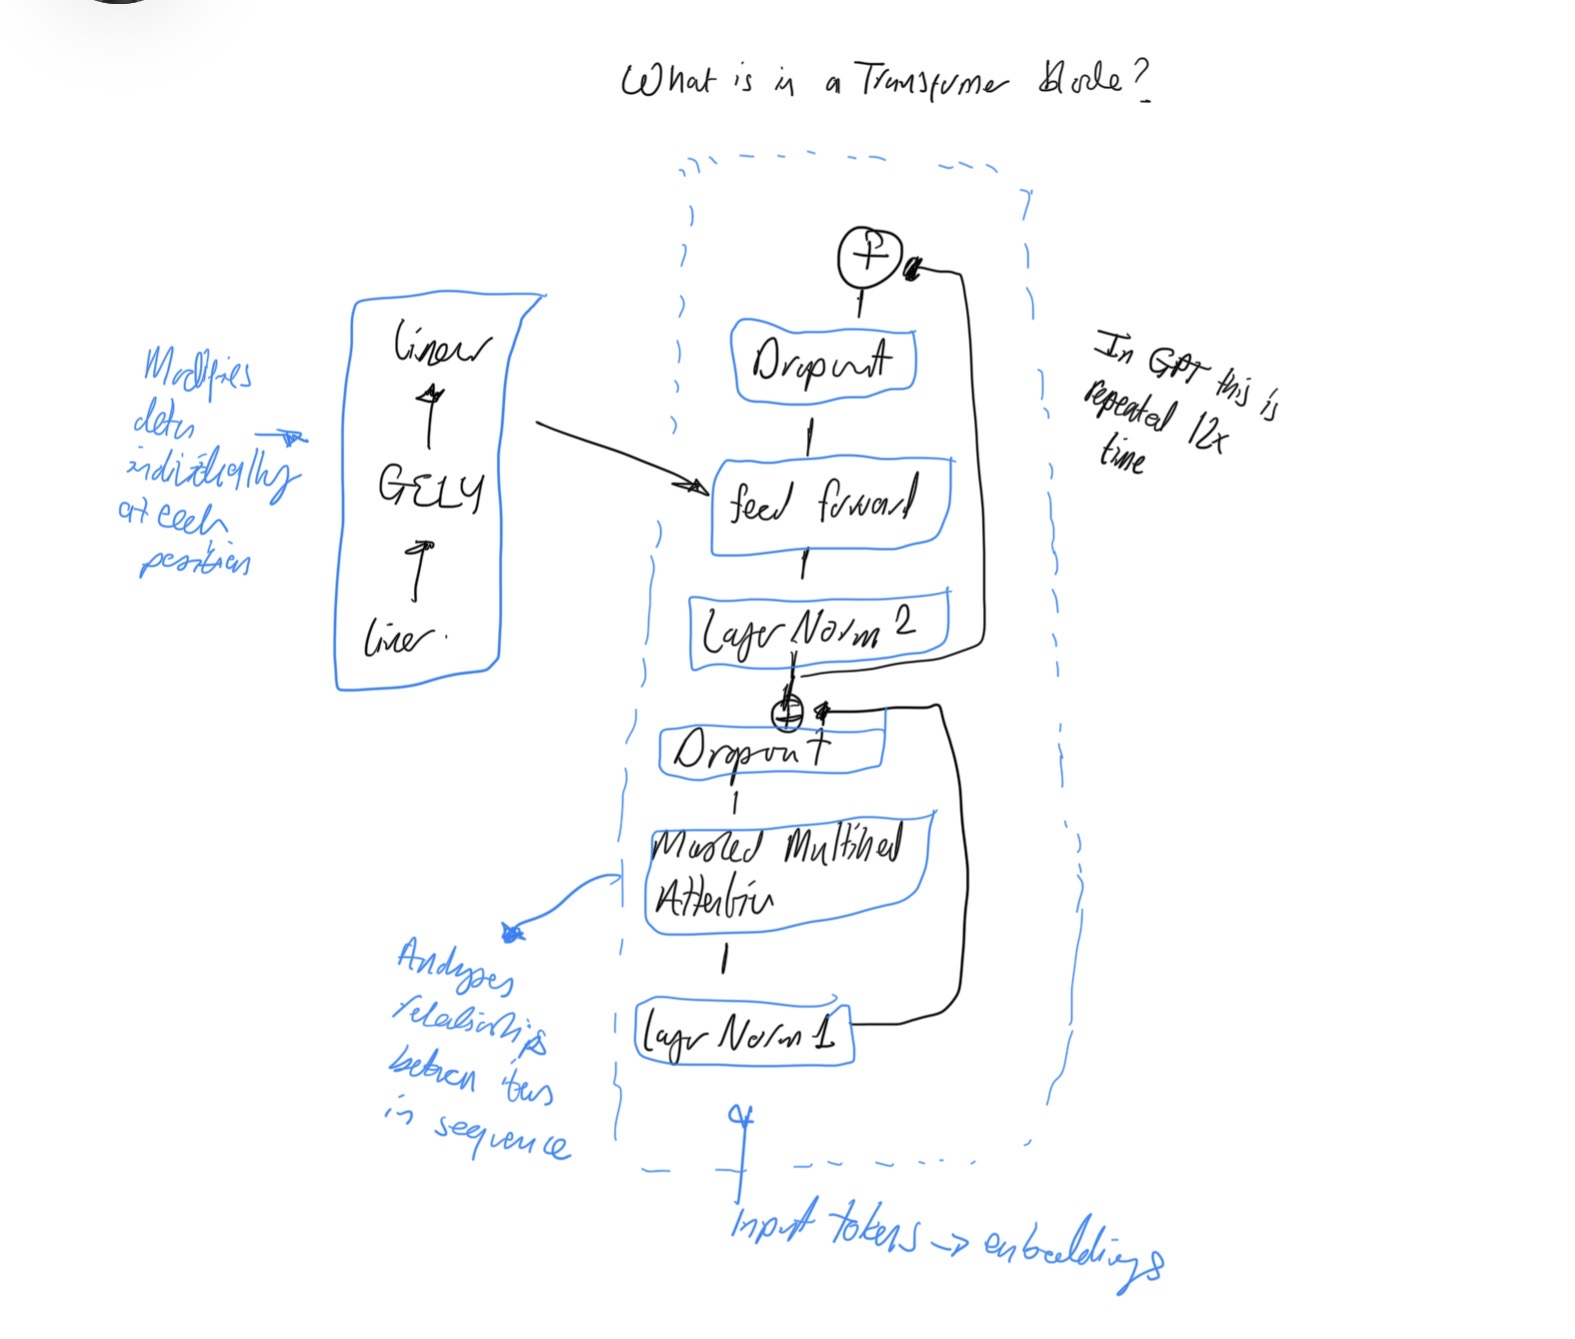

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads" ##This is key for the splits below

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    #1 reduces projection dimension to desired output
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)    #2 use a linear layer to cmbine outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape
        keys = self.W_key(x)         #3 compute keys
        queries = self.W_query(x)    #3 compute queries
        values = self.W_value(x)     #3 compute values

        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       #4 #split matrix by adding a number of heads value
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(
            batch_size, num_tokens, self.num_heads, self.head_dim
        )

        keys = keys.transpose(1, 2)          #5 Transpose for multiplication
        queries = queries.transpose(1, 2)    #5 Transpose for multiplication
        values = values.transpose(1, 2)      #5 Transpose for multiplication
        attn_scores = queries @ keys.transpose(2, 3)   #6 for product per head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #7

        attn_scores.masked_fill_(mask_bool, -torch.inf)     #8 mask tokens - fill attention scores

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)   #9 calculate the context  vector
                                                          #10 Combine the heads

        '''
        The context vectors from all heads are transposed back to the shape (b, num_tokens, num_heads, head_dim).
        These vectors are then reshaped (flattened) into the shape (b, num_tokens, d_out), effectively combining the outputs from all heads.
        '''
        context_vec = context_vec.contiguous().view(
            batch_size, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)    #11 linear projection of context vector
        return context_vec

In [31]:


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
 #1
        shortcut = x #shortcut for attention block
        x = self.norm1(x) ## Pre-LayerNorm; added before attention, dropout. PostLayerNorm would add after.
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      # add layers

        shortcut = x         #3 shortcut for feedforward block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #4 add layers: 'adds the input of the block to its output'
        return x

In [32]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                   #1
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


#### A closing note on dimensions

We keep the input dims the same as the output dims so we can stack the Transformer layers effectively. However, output dim is a context vector that has info about the entire sequences.

While physical dims are unchanged as they pass through transformers, the content of each output vector is re-encoded to contain really important information about the full sequence.



## 4.6 Coding the GPT model
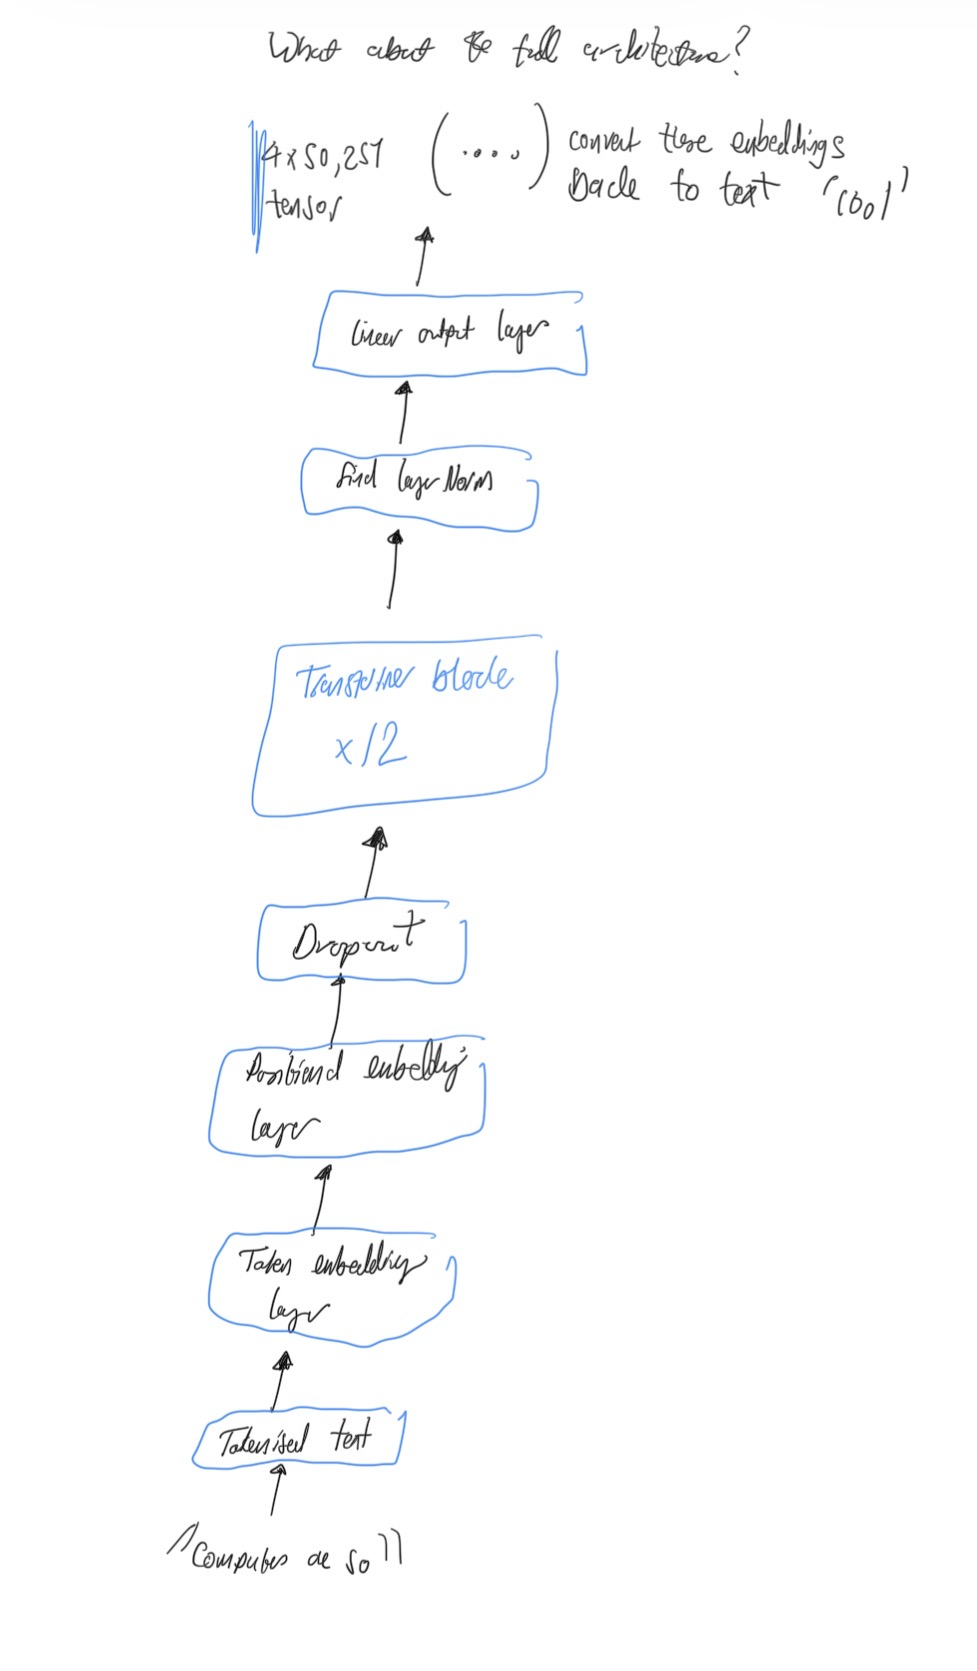

In [34]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
 #1
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x) ##apply dropout
        x = self.trf_blocks(x) ##apply transformer blocks
        x = self.final_norm(x) ##last normaliation
        logits = self.out_head(x) ##linear layer to get unnormalised probabilities of next word
        return logits

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


### Why 163m and not 124m parameters?

This is due to weight-tying. In original GPT-2, it reuses the weights from the token embedding layer in its output layer.

We remove the output layer's weights from our calculation.

Why? It reduces memory footprint and computational complexity. However, Raschka notes that using separate token embeddings and output layers results in better model performance. So we use sep layers in our GPT implementation.

In [38]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)


Number of trainable parameters considering weight tying: 124,412,160
